# COIN-OR: MILP (Gemischt-ganzzahlige Optimierung)

- CBC (mit PuLP, mit CyLP)
- HiGHS (mit PuLP, mit highspy)
- SYMPHONY


In [3]:
import json
import pandas as pd

In [4]:
from utils.plotter import plot_gantt_jobs
from utils.plotter import plot_gantt_machines
from utils.simple_priority_heuristics import schedule_spt

In [5]:
# Datei laden
with open("data/jobshop_instances_named.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

In [6]:
#instance =  jobshop_instances["instance la10"]
instance =  jobshop_instances["instance ft10"]
job_order = sorted(instance, key=lambda x: int(x.split()[1]))  # "job 0", "job 1", ...
matrix = [instance[job_name] for job_name in job_order]
for job in matrix:
    print(job)

[[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
[[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
[[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
[[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
[[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
[[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
[[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
[[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
[[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
[[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]


In [7]:
def get_number_of_machines(job_shop_matrix):
    machines = set()
    for job in job_shop_matrix:
        for operation in job:
            machine_id = operation[0]
            machines.add(machine_id)
    return len(machines)

print(get_number_of_machines(matrix))

10


In [8]:
def check_machine_conflicts(df):
    # Sortiere DataFrame nach Machine und Startzeit
    df_sorted = df.sort_values(by=["Machine", "Start"]).reset_index(drop=True)

    conflict_count = 0

    # Überprüfe jede Maschine einzeln
    for machine in df_sorted["Machine"].unique():
        machine_df = df_sorted[df_sorted["Machine"] == machine].sort_values(by="Start")

        # Zeilenweise durchgehen und Startzeiten vergleichen
        for i in range(1, len(machine_df)):
            prev_end = machine_df.iloc[i - 1]["End"]
            curr_start = machine_df.iloc[i]["Start"]

            if curr_start < prev_end:
                conflict_count += 1

    print(f"Gefundene Konflikte auf Maschinen: {conflict_count}")
    return conflict_count == 0


In [9]:
def check_job_machine_sequence(df, job_matrix):
    violations = 0

    for job_id, job_ops in enumerate(job_matrix):
        # Hole Einträge dieses Jobs aus dem DataFrame
        job_df = df[df["Job"] == f"Job {job_id}"].copy()
        job_df.sort_values("Start", inplace=True)

        # Extrahiere tatsächliche Maschinenreihenfolge aus dem Zeitplan
        actual_sequence = job_df["Machine"].str.extract(r"M(\d+)").astype(int)[0].tolist()
        expected_sequence = [op[0] for op in job_ops]

        if actual_sequence != expected_sequence:
            print(f"⚠️ Reihenfolge-Verletzung bei Job {job_id}:")
            print(f"  Erwartet: {expected_sequence}")
            print(f"  Gefunden: {actual_sequence}")
            violations += 1

    print(f"\nAnzahl verletzter Job-Maschinen-Reihenfolgen: {violations}")
    return violations == 0


## Vergleichansatz (ohne Optimierung)

### SPT – Shortest Processing Time

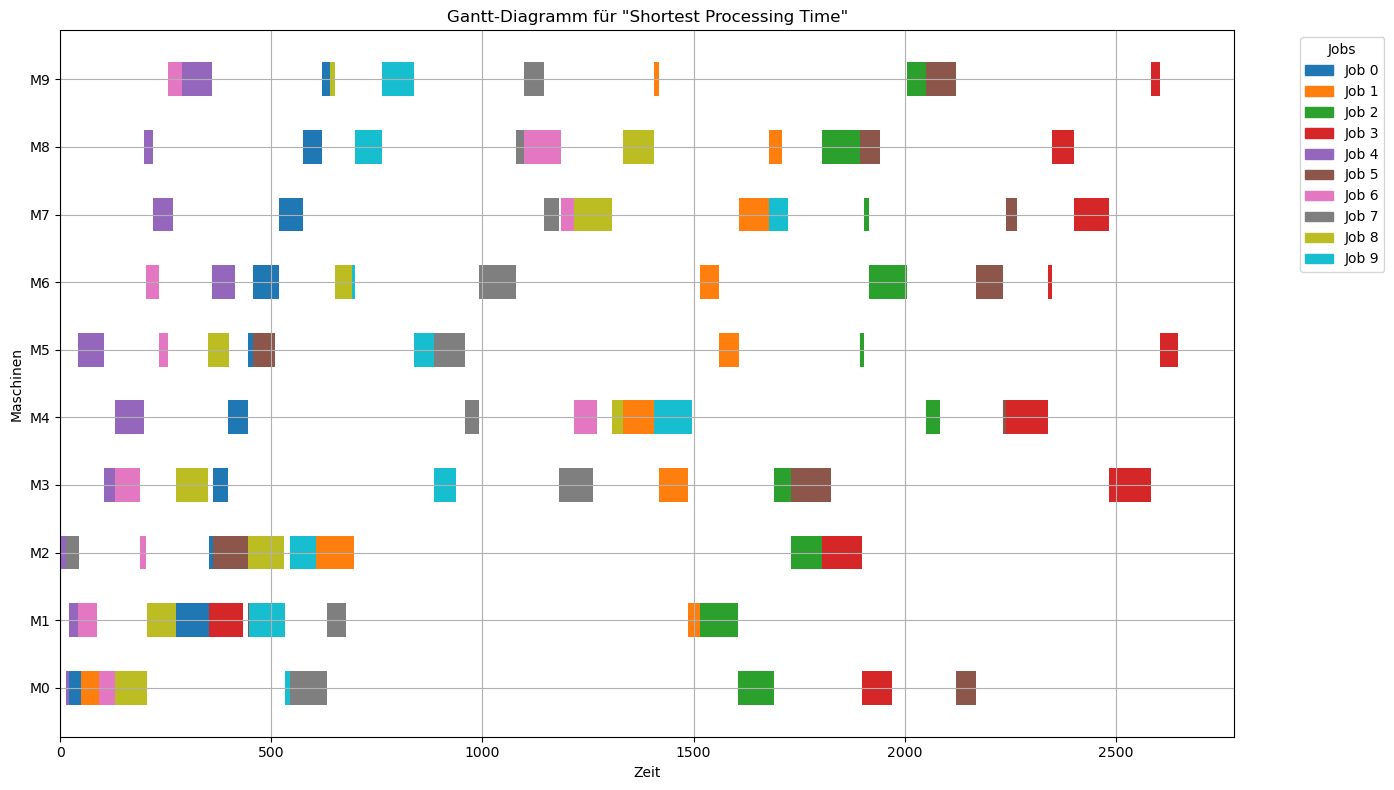

In [12]:
df_spt = schedule_spt(matrix)
df = df_spt
category = "Shortest Processing Time"

# plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category))

In [13]:
makespan_spt = df_spt['End'].max()
print(f"Makespan (Gesamtbearbeitungszeit): {makespan_spt} Zeiteinheiten")

Makespan (Gesamtbearbeitungszeit): 2648 Zeiteinheiten


# CBC

In [15]:
from pulp import LpProblem, LpMinimize, LpVariable, LpStatus, PULP_CBC_CMD, value

# Aufgaben und Zeiten (Job, Zeit)
data = matrix

In [16]:
num_jobs = len(data)
num_tasks = len(data[0])
num_machines = 10

# Modell definieren
model = LpProblem("Job_Shop_Scheduling", LpMinimize)

# Variablen für Startzeiten
start_times = {
    (j, t): LpVariable(f"Start_{j}_{t}", lowBound=0, cat="Continuous")
    for j in range(num_jobs) for t in range(num_tasks)
}
makespan = LpVariable("Makespan", lowBound=0, cat="Continuous")

# Ziel: Makespan minimieren
model += makespan

# Technologische Reihenfolge
for j in range(num_jobs):
    for t in range(num_tasks - 1):
        dur = data[j][t][1]
        model += start_times[(j, t)] + dur <= start_times[(j, t + 1)]

# Maschinenkonflikte
for m in range(num_machines):
    ops_on_machine = []
    for j in range(num_jobs):
        for t, (machine, duration) in enumerate(data[j]):
            if machine == m:
                ops_on_machine.append((j, t, duration))
    for i in range(len(ops_on_machine)):
        j1, t1, d1 = ops_on_machine[i]
        for j2, t2, d2 in ops_on_machine[i + 1:]:
            y = LpVariable(f"y_{j1}_{t1}_before_{j2}_{t2}_M{m}", cat="Binary")
            model += start_times[(j1, t1)] + d1 <= start_times[(j2, t2)] + (1 - y) * 1e5
            model += start_times[(j2, t2)] + d2 <= start_times[(j1, t1)] + y * 1e5

# Makespan muss letzte Operation jedes Jobs einschließen
for j in range(num_jobs):
    last_t = num_tasks - 1
    model += start_times[(j, last_t)] + data[j][last_t][1] <= makespan

# Problem lösen
model.solve(PULP_CBC_CMD(msg=True, timeLimit=300))

# Optimierungsstatus ausgeben
print("\n Optimierungsstatus:", LpStatus[model.status])
print(" Makespan:", value(makespan))


 Optimierungsstatus: Optimal
 Makespan: 1200.0


In [17]:
# DataFrame mit Ergebnis
schedule_data = []
for (j, t), var in sorted(start_times.items()):
    s = var.varValue
    if s is not None:
        machine, duration = data[j][t]
        schedule_data.append({
            "Job": f"Job {j}",
            "Machine": f"M{machine}",
            "Start": round(s, 1),
            "Duration": duration,
            "End": round(s + duration, 1)
        })

df_schedule_cbc = pd.DataFrame(schedule_data)

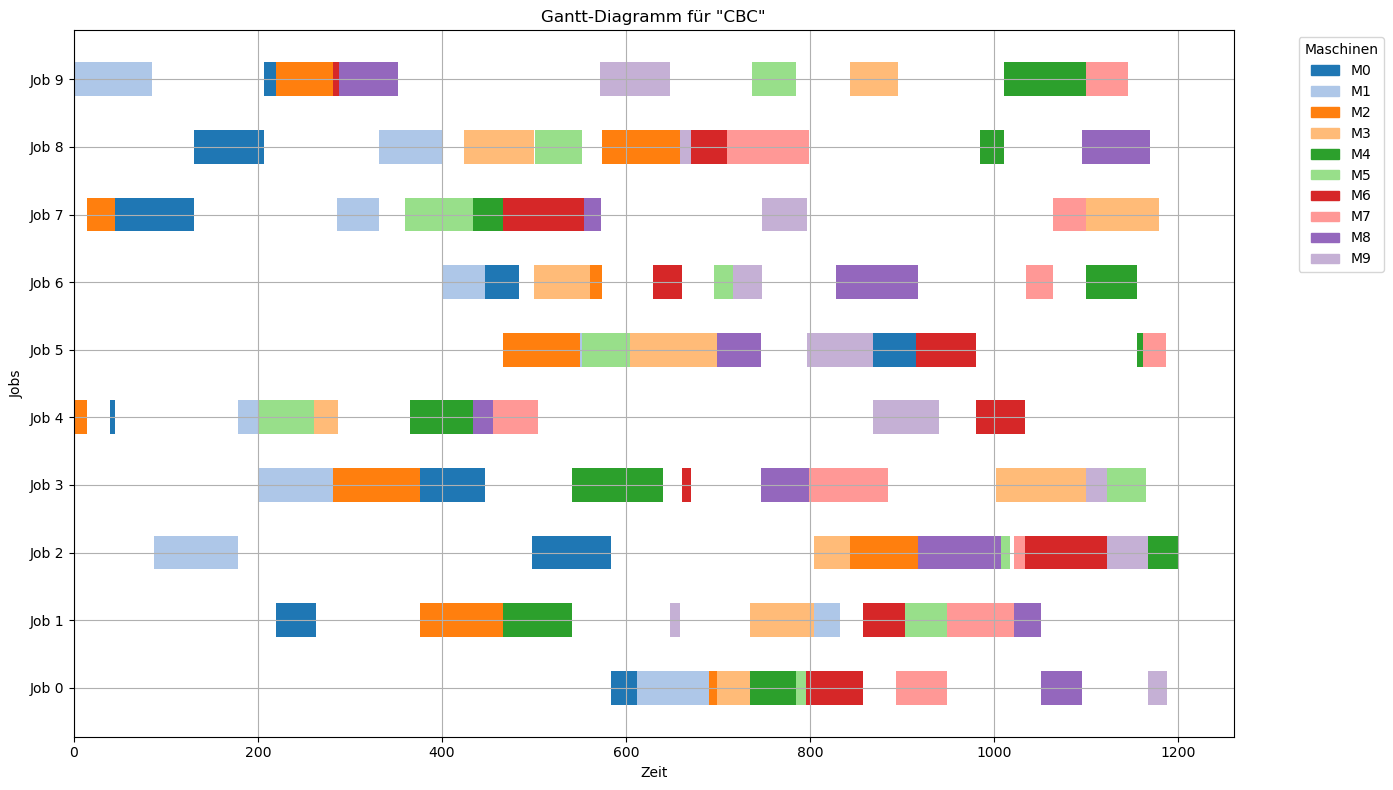

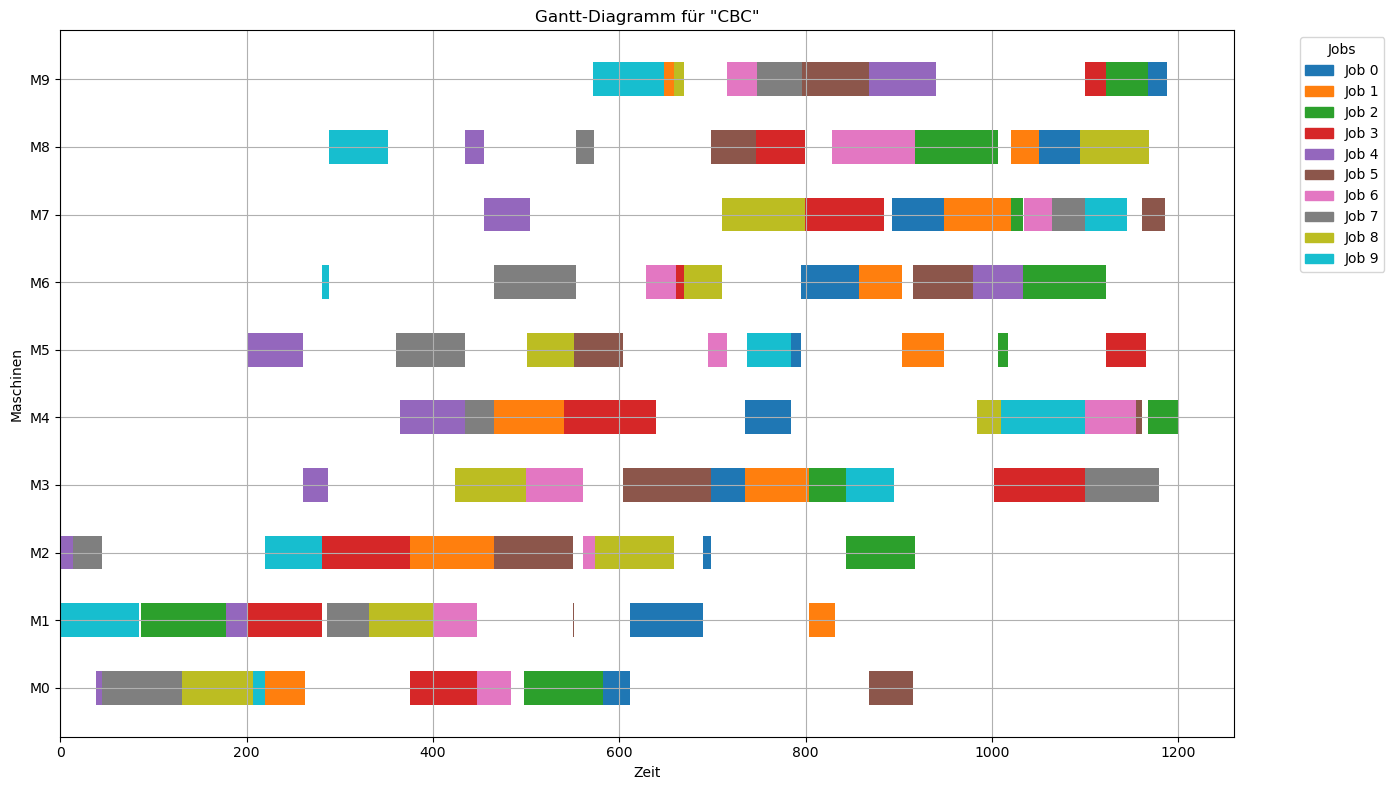

In [18]:
category = "CBC"

plot_gantt_jobs(df_schedule_cbc, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df_schedule_cbc, 'Gantt-Diagramm für "{}"'.format(category))

In [19]:
makespan_cbc = df_schedule_cbc['End'].max()
print(f"Makespan (Gesamtbearbeitungszeit): {makespan_cbc} Zeiteinheiten")
print(f"CBC hat einen ~{round(makespan_spt/makespan_cbc, 1)}-fach kürzeren Makespan gefunden (als SPT)")

Makespan (Gesamtbearbeitungszeit): 1200.0 Zeiteinheiten
CBC hat einen ~2.2-fach kürzeren Makespan gefunden (als SPT)


In [20]:
check_machine_conflicts(df_schedule_cbc)
check_job_machine_sequence(df_schedule_cbc, matrix)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True

# HiGHS mit PuLP

In [22]:
# pip install PuLP
# conda install -c conda-forge highs

In [23]:
import pulp

In [24]:
num_jobs = len(matrix)
num_machines = get_number_of_machines(matrix)

# LP-Problem: Minimierung des Makespans
prob = pulp.LpProblem("JobShop_Optimal_HiGHS", pulp.LpMinimize)

# Variablen: Startzeiten
starts = {
    (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
    for j in range(num_jobs) for o in range(len(matrix[j]))
}

# Makespan-Variable
makespan = pulp.LpVariable("makespan", lowBound=0, cat="Continuous")

# Ziel: Minimierung des Makespans
prob += makespan

# Technologische Reihenfolge (innerhalb eines Jobs)
for j in range(num_jobs):
    for o in range(1, len(matrix[j])):
        d_prev = matrix[j][o - 1][1]
        prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

# Maschinenkonflikte (Disjunktivbedingungen)
bigM = 10000
for m in range(num_machines):
    ops = [(j, o, d) for j in range(num_jobs)
           for o, (mach, d) in enumerate(matrix[j]) if mach == m]
    for i in range(len(ops)):
        j1, o1, d1 = ops[i]
        for j2, o2, d2 in ops[i + 1:]:
            if j1 != j2:
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += starts[(j1, o1)] + d1 <= starts[(j2, o2)] + bigM * (1 - y)
                prob += starts[(j2, o2)] + d2 <= starts[(j1, o1)] + bigM * y

# Makespan: spätester Endzeitpunkt
for j in range(num_jobs):
    last_op = len(matrix[j]) - 1
    prob += makespan >= starts[(j, last_op)] + matrix[j][last_op][1]

# Solver: HiGHS
print("[INFO] Starte Lösung mit HiGHS...")
solver = pulp.HiGHS_CMD(msg=True, timeLimit=300)  # solver = pulp.HiGHS_CMD(threads=4, msg=True, timeLimit=300)
# solver = pulp.HiGHS_CMD(path="C:/tools/HiGHS/build/bin/Release/highs.exe", msg=True, timeLimit=300) # Windows

prob.solve(solver)

# Ergebnisse
status = pulp.LpStatus[prob.status]
print(f"\nStatus       : {status}")
print(f"Makespan     : {pulp.value(makespan)}")

# Zeitplan extrahieren
schedule_data = []

for (j, o), var in sorted(starts.items()):
    start = var.varValue
    if start is not None:
        machine, duration = matrix[j][o]
        end = start + duration
        schedule_data.append({
            "Job": f"Job {j}",
            "Machine": f"M{machine}",
            "Start": round(start, 1),
            "Duration": duration,
            "End": round(end, 1)
        })

df_schedule_highs = pd.DataFrame(schedule_data)

[INFO] Starte Lösung mit HiGHS...

Status       : Optimal
Makespan     : 996.0


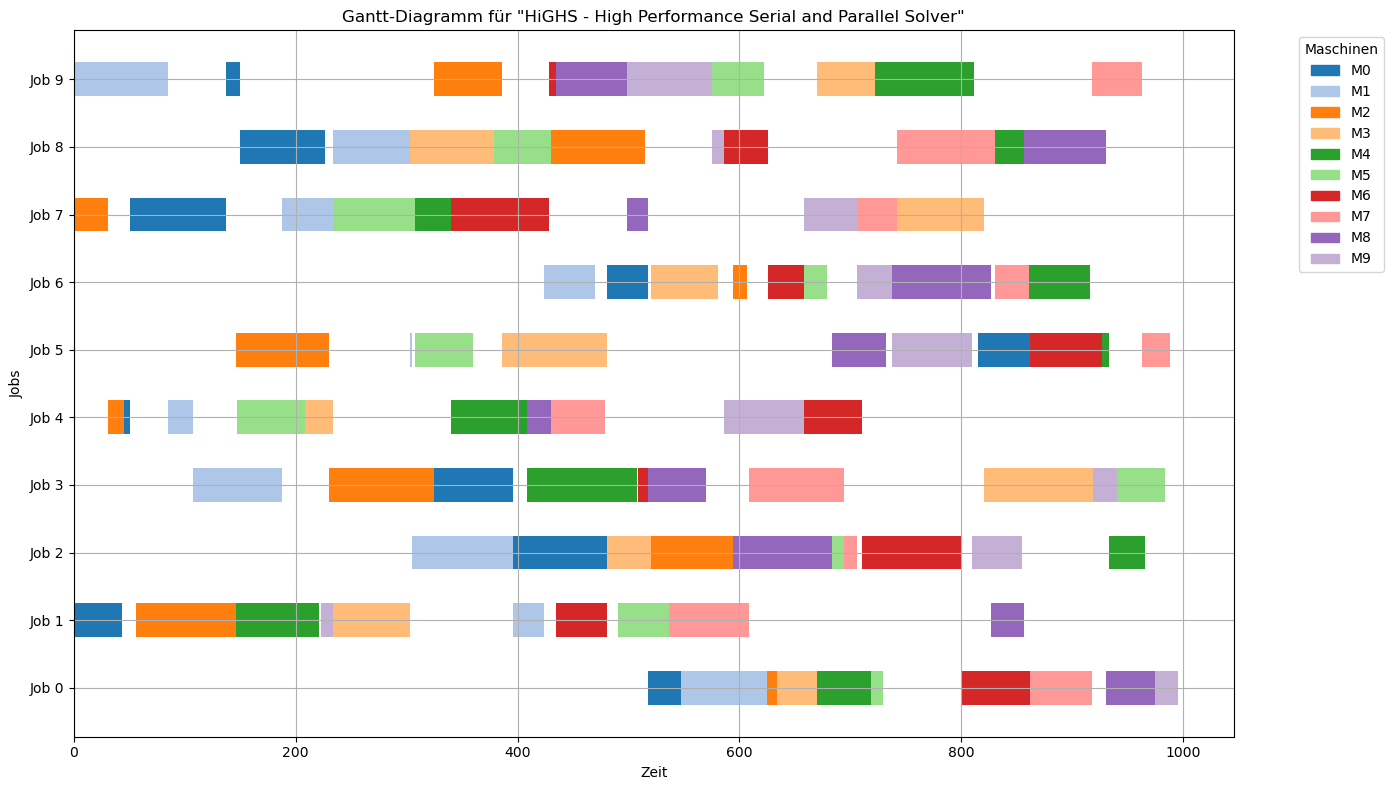

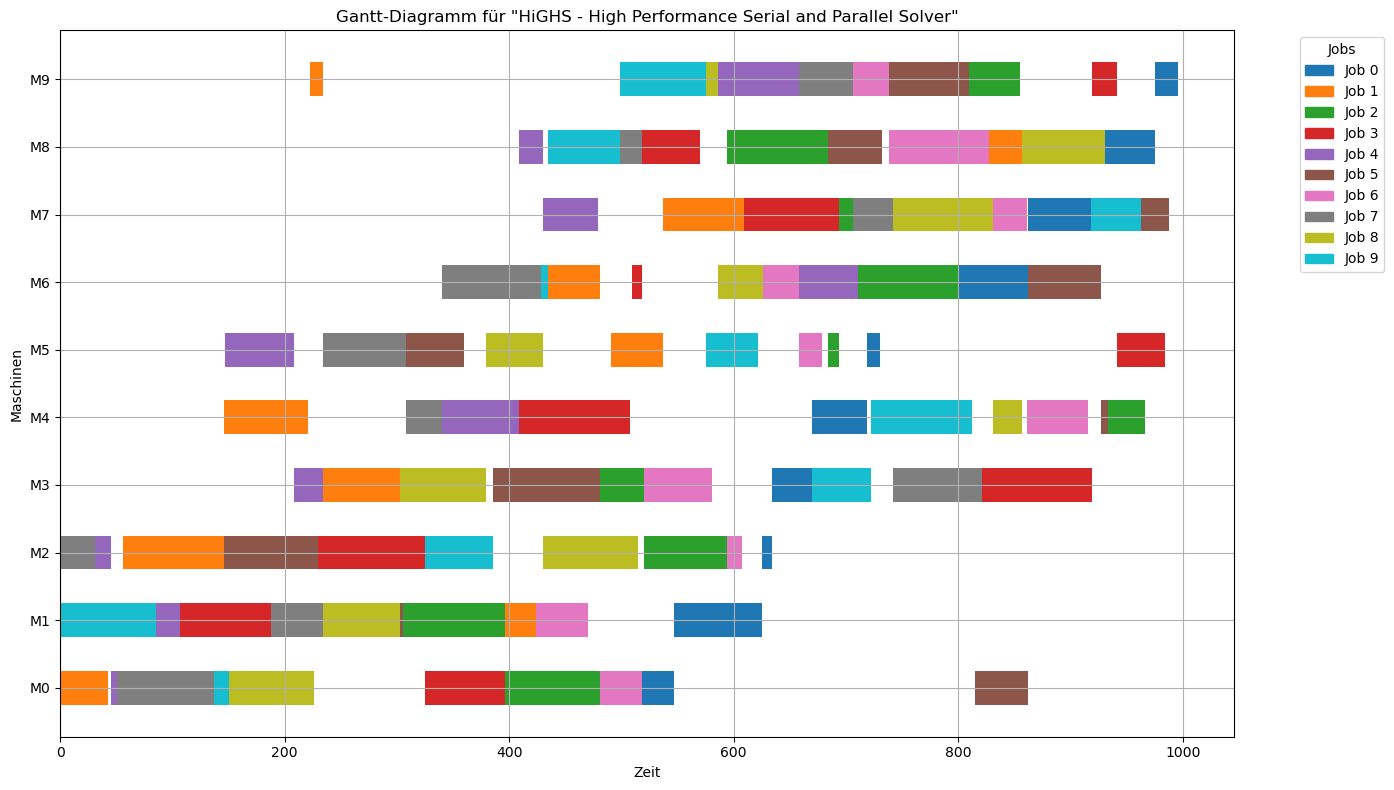

In [25]:
df = df_schedule_highs
category = "HiGHS - High Performance Serial and Parallel Solver"

plot_gantt_jobs(df, 'Gantt-Diagramm für "{}"'.format(category))
plot_gantt_machines(df, 'Gantt-Diagramm für "{}"'.format(category))

In [26]:
makespan_highs = df_schedule_highs['End'].max()
print(f"Makespan (Gesamtbearbeitungszeit): {makespan_highs} Zeiteinheiten")
print(f"HiGHS hat einen ~{round(makespan_spt/makespan_highs, 1)}-fach kürzeren Makespan gefunden (als SPT)")

Makespan (Gesamtbearbeitungszeit): 996.0 Zeiteinheiten
HiGHS hat einen ~2.7-fach kürzeren Makespan gefunden (als SPT)


In [27]:
check_machine_conflicts(df_schedule_highs)
check_job_machine_sequence(df_schedule_highs, matrix)

Gefundene Konflikte auf Maschinen: 0

Anzahl verletzter Job-Maschinen-Reihenfolgen: 0


True